In [1]:

import numpy as np
import scipy.io as sio


import F2O.F2O_utils as F2O
import F2O.constants as f2oDef
from F2O.imgUtils.image_utils import ImgMetrics, ImgPlot, ImgRead, ImgApplyFwNoise

from F2O.fwOp.fwOperator import fwOp

from F2O.noise.noiseModels import noiseModels

from F2O.PG_sptl import apg as APG



# If you get an error while loading the F2O, then
# 
# * Exit Jupyter
# * Go to the F2O root dir, and execute
#      export PYTHONPATH=$PYTHONPATH:`pwd`
# * Relaunch Jupyter
#



No module named 'pyopencl'. cl12 version by Christoph Gohlke for windows is recommended: https://www.lfd.uci.edu/~gohlke/pythonlibs/#pyopencl


## Read input images

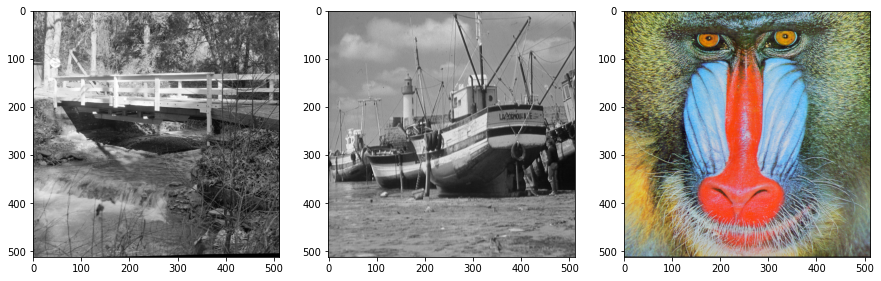

In [2]:
# -------------------
# --- Read images ---
# -------------------

import requests
from io import BytesIO

# Test images from the SIPI image database
fname = {0: requests.get('http://sipi.usc.edu/database/misc/5.2.10.tiff'),   # bridge (grayscale)
         1: requests.get('http://sipi.usc.edu/database/misc/boat.512.tiff'), # boat (grayscale)
         2: requests.get('http://sipi.usc.edu/database/misc/4.2.03.tiff'),   # mandrill (color)
        }

testImgs = ImgRead(enableJAX=False)        # If JAX is installed but just want to use 
                                           # standard numpy, then we need to pass this flag (once)

testImgs.list.append([BytesIO(fname.get(0).content),'g'])
testImgs.list.append([BytesIO(fname.get(1).content),'g'])
testImgs.list.append([BytesIO(fname.get(2).content),'c'])


u = testImgs.readListImgs()                  # read list of images, normalize them between 0 and 1
                                             # u   : original image

pltImg  = ImgPlot()
pltImg.plotNImgs(u, len(u), None, 5)    

## Define forward Op (Identity for this example)

In [3]:
# Set "Ax" (forward) function
Op = []
  
Op.append( fwOp() )             
Op[0].linOp = f2oDef.fAx.Identity
Op[0].label = "Identity"
Op[0].padFlag   = True            # pad input image
Op[0].boundary  = 'symm'          # use symmetric boundary conditions
Op[0].mode      = 'same'          # output (convolution) has the same size as input
Op[0].vecFlag   = True            # input / output data are asumed / forced to be vectorized



## Generate the observed image

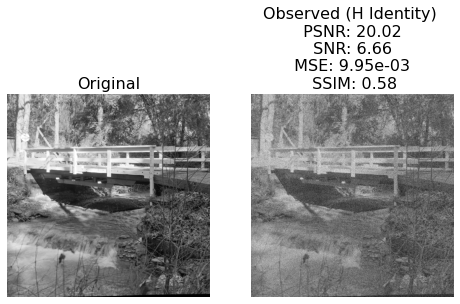

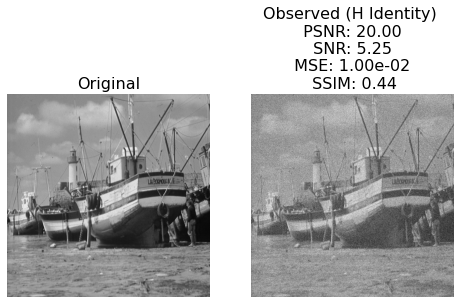

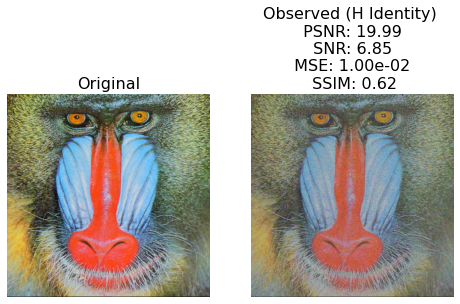

In [4]:
# --------------------------------------
# --- Set parameters for noise model ---
# --------------------------------------
    
sigma = 0.1
noise = noiseModels()

if sigma > 0:
    noise.model = f2oDef.noise.Gaussian
    noise.mean  = 0.
    noise.sigma = sigma

else:
    noise.model = f2oDef.noise.Null


# --------------------------------------
# --- Apply forward model plus noise ---
# --------------------------------------

applyModel = ImgApplyFwNoise(u, Op, noise)  # Applies the model to all images using all Op
                                            # in u. NOTE: u can be
                                            # * a data array
                                            # * a list of data arrays

applyModel.computeMetrics = True            # This option is handy when performing comparisons
applyModel.displayImgs    = True

b, metrics, pltImg = applyModel.obsImg()    # b is a list
                                            # b[k][n] : k <--> index for images
                                            #           n <--> index for Op

for k in range(len(u)):
      pltImg.plotNImgs(pltImg.imgShow[k], len(Op)+1, pltImg.txtN[k])


## Define the optimization problem

In [5]:
# --------------------------------------
# Define parameter optimization variable 
# --------------------------------------

args = F2O.argsF2O()
  
args.verbose    = True
args.fCostClass = f2oDef.cost.L2TV_lin      # f(x) = 0.5|| fAx(x) - b ||_2^2 + \lambda|| \nabla x ||_1, 
                                            #        where fAx is lineal

args.ssPolicy = f2oDef.ss.dualTV 

args.freqSol         = False
args.padFlag         = True
args.padMode         = 'symmetric' 

## Solve the actual problem

In [10]:
# select image and blur

k = { 'bridge':   0,  # grayscale
      'boats':    1,  # grayscale
      'mandrill': 2,  # color
    }.get('mandrill')

n = 0  # operator

lmbda = 0.05
nIter = 50             

sol   = APG(Op[n], b[k][n], lmbda, nIter, args)

xRec = np.clip(sol[0], 0., 1.)

recMetrics = ImgMetrics()
recMetrics.appendEmpty()
recMetrics.computeAll(u[k],xRec,0)



Iter 	 Cost 		 step-size     Time     |x_k - x_{k-1}|
  0	 1.283e+05	 2.50e+00    1.49e-01    nan
 10	 1.175e+05	 2.50e+00    1.48e+00    2.566e-02
 20	 1.175e+05	 2.50e+00    2.79e+00    7.424e-03
 30	 1.175e+05	 2.50e+00    4.10e+00    3.258e-03
 40	 1.175e+05	 2.50e+00    5.41e+00    1.776e-03
 49	 1.175e+05	 2.50e+00    6.60e+00    1.162e-03


## Show results

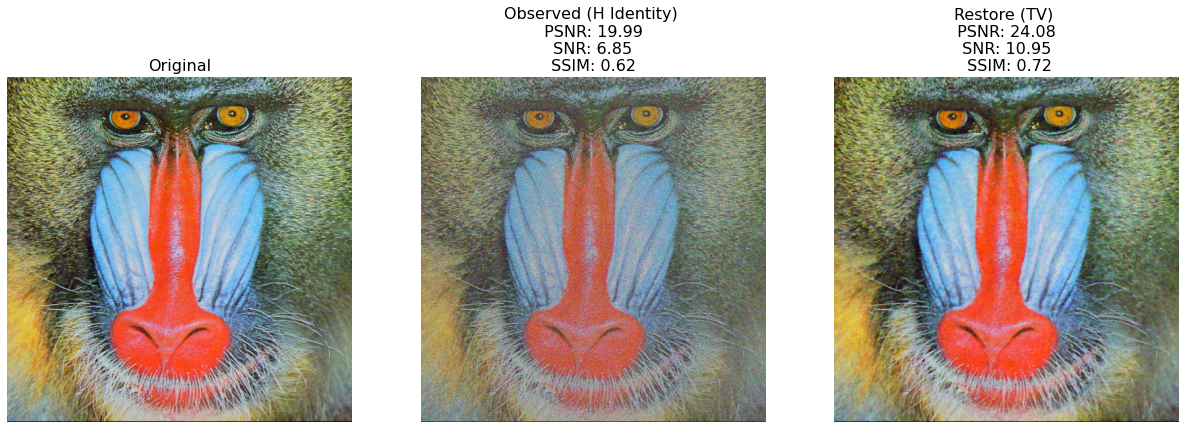

In [11]:



recStats = np.zeros( (3,1) )

recStats[0,0] = metrics.snr(u[k], xRec)
recStats[1,0] = metrics.psnr(u[k], xRec)
recStats[2,0] = metrics.ssim(u[k], xRec)

txtRec     = []
    
txtRec.append('Original')
txtRec.append('Observed (H {}) \n PSNR: {:1.2f} \n SNR: {:1.2f} \n SSIM: {:1.2f} '.format(Op[n].label,metrics.valPsnr[k][n],metrics.valSnr[k][n],metrics.valSsim[k][n]))
txtRec.append('Restore (TV) \n PSNR: {:1.2f} \n SNR: {:1.2f} \n SSIM: {:1.2f}'.format(recMetrics.valPsnr[0][n],recMetrics.valSnr[0][n],recMetrics.valSsim[0][n]))
        
    
pltImg.plotNImgs([u[k], b[k][n], xRec], 3, txtRec, winSize=7)     
